In [2]:
import ROOT
import uproot
import numpy as np
import pandas as pd
import torch 
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.22/00


In [3]:
sig_df = pd.read_pickle('DNN_ips/SUSY_Mstop_227_5_mchi_60.pkl')
tt_df  = pd.read_pickle('DNN_ips/ttbar.pkl')
vv_df  = pd.read_pickle('DNN_ips/VV.pkl')
st_df  = pd.read_pickle('DNN_ips/Single_top.pkl')
sat_df = pd.read_pickle('DNN_ips/Single_antitop.pkl')

In [3]:
Pol_rw  = np.loadtxt('txt_files/SUSY_weights_mstop_175_mchi_7_5_Pol_minus1.txt')
Ecom_rw = np.loadtxt('txt_files/SUSY_Ecom_rw.txt')
Rw      = Pol_rw * Ecom_rw

In [3]:
# Standardize
sig_mean = sig_df.mean()
sig_std  = sig_df.std()

tt_mean = tt_df.mean()
tt_std  = tt_df.std()

st_mean = st_df.mean()
st_std  = st_df.std()

vv_mean = vv_df.mean()
vv_std  = vv_df.std()

sat_mean = sat_df.mean()
sat_std  = sat_df.std()

sig_df = (sig_df - sig_mean)/ sig_std
tt_df  = (tt_df  - tt_mean)/ tt_std
st_df  = (st_df  - st_mean)/ st_std
vv_df  = (vv_df  - vv_mean)/ vv_std
sat_df = (sat_df  - sat_mean)/ sat_std

In [4]:
# Set both to equal sizes 
# Reducing the bkg dataframe size

sig_df_train = sig_df[1:15000]
tt_df_train  = tt_df[1:30000]
st_df_train  = st_df[1:5000]
sat_df_train = sat_df[1:5000]
vv_df_train  = vv_df[1:2000]

In [5]:
bkgList = [tt_df_train, st_df_train, sat_df_train, vv_df_train]  # List of your dataframes

bkg_df_train = pd.concat(bkgList)

signal = sig_df_train.values
bkg    = bkg_df_train.values

sig_label = np.ones(len(signal))
bkg_label = np.zeros(len(bkg))

data      = np.concatenate((signal,bkg))
label     = np.concatenate((sig_label,bkg_label))

In [6]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2, shuffle=True)
skf.get_n_splits(data, label)
skf.split(data, label)

<generator object _BaseKFold.split at 0x7ff5ef570ba0>

In [7]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]

TRAIN: [    3     5     6 ... 56990 56991 56993] TEST: [    0     1     2 ... 56988 56992 56994]
TRAIN: [    0     1     2 ... 56988 56992 56994] TEST: [    3     5     6 ... 56990 56991 56993]


In [8]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [9]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from skopt import gp_minimize

model = Sequential()
model.add(Dense(100, input_dim = 19  ,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(100, input_dim = 100 ,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2000      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 12,201
Trainable params: 12,201
Non-trainable params: 0
_________________________________________________________________


2021-02-26 01:35:05.630052: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-02-26 01:35:05.676869: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff5f3d68d90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-02-26 01:35:05.676888: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [10]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [11]:
hist = model.fit(x_train, y_train, batch_size=100, epochs=1000,verbose=1, shuffle=True, validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min'),
                  ModelCheckpoint(filepath='model.h5', verbose=0)])

Epoch 1/1000
228/228 [==============================] - 1s 4ms/step - loss: 0.6061 - accuracy: 0.7090 - val_loss: 0.5769 - val_accuracy: 0.7404
Epoch 2/1000
228/228 [==============================] - 1s 3ms/step - loss: 0.5873 - accuracy: 0.7348 - val_loss: 0.5807 - val_accuracy: 0.7404
Epoch 3/1000
228/228 [==============================] - 1s 3ms/step - loss: 0.5843 - accuracy: 0.7351 - val_loss: 0.5766 - val_accuracy: 0.7404
Epoch 4/1000
228/228 [==============================] - 1s 3ms/step - loss: 0.5826 - accuracy: 0.7360 - val_loss: 0.5741 - val_accuracy: 0.7404
Epoch 5/1000
228/228 [==============================] - 1s 3ms/step - loss: 0.5797 - accuracy: 0.7357 - val_loss: 0.5716 - val_accuracy: 0.7404
Epoch 6/1000
228/228 [==============================] - 1s 3ms/step - loss: 0.5791 - accuracy: 0.7359 - val_loss: 0.5725 - val_accuracy: 0.7405
Epoch 7/1000
228/228 [==============================] - 1s 4ms/step - loss: 0.5766 - accuracy: 0.7354 - val_loss: 0.5701 - val_accuracy:

228/228 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.90 - 1s 4ms/step - loss: 0.2180 - accuracy: 0.9049 - val_loss: 0.2034 - val_accuracy: 0.9139
Epoch 114/1000
228/228 [==============================] - 1s 4ms/step - loss: 0.2182 - accuracy: 0.9055 - val_loss: 0.2051 - val_accuracy: 0.9133
Epoch 115/1000
228/228 [==============================] - 1s 3ms/step - loss: 0.2179 - accuracy: 0.9063 - val_loss: 0.1998 - val_accuracy: 0.9181
Epoch 116/1000
228/228 [==============================] - 1s 3ms/step - loss: 0.2203 - accuracy: 0.9030 - val_loss: 0.2052 - val_accuracy: 0.9156
Epoch 117/1000
228/228 [==============================] - 1s 3ms/step - loss: 0.2212 - accuracy: 0.9041 - val_loss: 0.1999 - val_accuracy: 0.9182
Epoch 118/1000
228/228 [==============================] - 1s 3ms/step - loss: 0.2210 - accuracy: 0.9043 - val_loss: 0.1999 - val_accuracy: 0.9149
Epoch 119/1000
228/228 [==============================] - 1s 3ms/step - loss: 0.2173 - accuracy: 

In [75]:
'''
# serialize model to JSON
model_json = model.to_json()
with open("Mstop_182_5_mchi_7_5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Mstop_182_5_mchi_7_5.h5")
print("Saved model to disk")
'''

Saved model to disk


In [12]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch', fontsize=17)
    plt.ylabel('Loss' , fontsize=17)
    plt.tick_params(axis="y", labelsize=15)
    plt.tick_params(axis="x", labelsize=15)
    plt.title('Cross Entropy Loss by Epoch', fontsize=17)
    color='C0'
    do_acc=False
    for label,loss in histories:
        #color = tuple(np.random.random(3))
        #colors.append(color)
        l = 'Training set loss'
        vl= 'Validation set loss'
        if 'acc' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['acc'][-1])
            do_acc = True
        if 'val_acc' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_acc'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)

    plt.legend(fontsize=17)
    #plt.yscale('log')
    plt.show()
    #if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    for i,(label,loss) in enumerate(histories):
        #color = colors[i]
        if 'acc' in loss.history:
            plt.plot(loss.history['acc'], lw=2, label=label+" accuracy", color=color)
        if 'val_acc' in loss.history:
            plt.plot(loss.history['val_acc'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)

    plt.show()

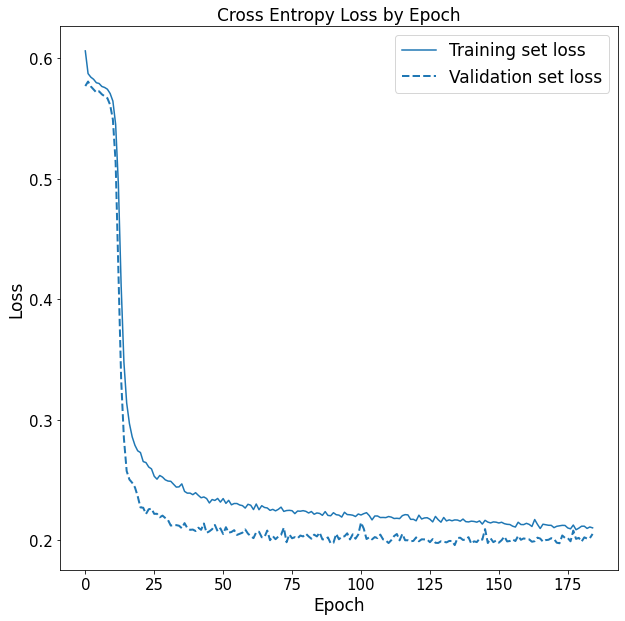

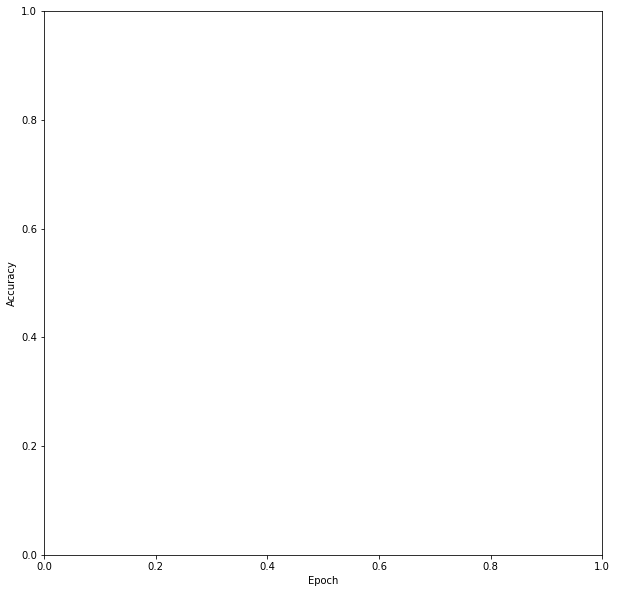

In [13]:
show_losses( [("Binary Cross Entropy Loss", hist)])

In [14]:
from sklearn.metrics import roc_curve
y_pred_train = model.predict(x_train).ravel()
y_pred_test  = model.predict(x_test).ravel()

fpr_keras_train, tpr_keras_train, thresholds_keras = roc_curve(y_train, y_pred_train)
fpr_keras_test , tpr_keras_test , thresholds_keras = roc_curve(y_test , y_pred_test)

In [15]:
from sklearn.metrics import auc
auc_keras_test  = auc(fpr_keras_test, tpr_keras_test)
auc_keras_train = auc(fpr_keras_train, tpr_keras_train)

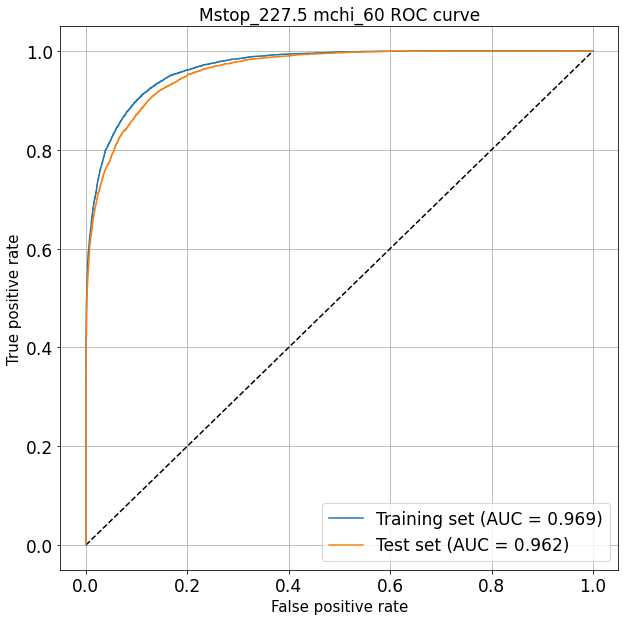

In [16]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_train, tpr_keras_train, label='Training set (AUC = {:.3f})'.format(auc_keras_train))
plt.plot(fpr_keras_test , tpr_keras_test , label='Test set (AUC = {:.3f})'.format(auc_keras_test))
plt.tick_params(axis="y", labelsize=17)
plt.tick_params(axis="x", labelsize=17)
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate' , fontsize=15)
plt.title('Mstop_227.5 mchi_60 ROC curve', fontsize=17)
plt.legend(loc='lower right', fontsize=17)
plt.grid()
plt.savefig('ROC Mstop 227.5 Mchi 60.jpg')
plt.show()

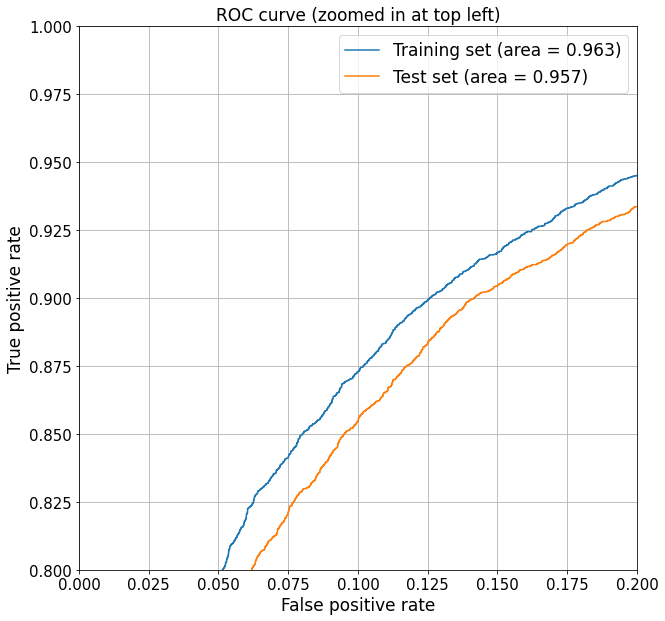

In [72]:
# Zoom in view of the upper left corner.
plt.figure(figsize=(10,10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_train, tpr_keras_train, label='Training set (area = {:.3f})'.format(auc_keras_train))
plt.plot(fpr_keras_test , tpr_keras_test , label='Test set (area = {:.3f})'.format(auc_keras_test))
plt.ylabel('True positive rate' , fontsize=17)
plt.xlabel('False positive rate', fontsize=17)
plt.tick_params(axis="y", labelsize=15)
plt.tick_params(axis="x", labelsize=15)
plt.title('ROC curve (zoomed in at top left)', fontsize=17)
plt.legend(loc='best', fontsize=17)
plt.grid()
plt.show()

In [38]:
tt_pred  = model.predict(tt_df[30000:]) 
st_pred  = model.predict(st_df[5000:]) 
sat_pred = model.predict(sat_df[5000:]) 
vv_pred  = model.predict(vv_df[2000:]) 
si_pred  = model.predict(sig_df[15000:])

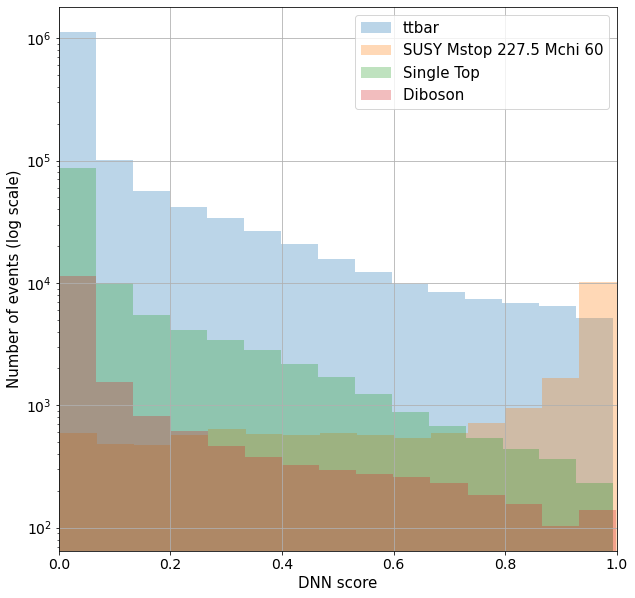

In [41]:
plt.figure(figsize=(10,10))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(tt_pred, bins=15, alpha=0.3, label='ttbar')
plt.hist(si_pred, bins=15, alpha=0.3, label='SUSY Mstop 227.5 Mchi 60')
plt.hist(st_pred, bins=15, alpha=0.3, label='Single Top')
plt.hist(vv_pred, bins=15, alpha=0.3, label='Diboson ')
#plt.hist(sat_pred, bins=15, alpha=0.3, label='Single Antitop')
plt.yscale('log')
plt.xlim(0,1)
plt.xlabel('DNN score', fontsize=15)
plt.ylabel('Number of events (log scale)', fontsize=15)
plt.grid()
plt.legend(loc='best', fontsize=15)
plt.savefig('DNN score Mstop_227.5 Mchi_60.jpg')

In [50]:
np.savetxt('Mstop_227_5_mchi_60_SUSY_pred.txt', si_pred)
np.savetxt('Mstop_227_5_mchi_60_tt_pred.txt'  , tt_pred)
np.savetxt('Mstop_227_5_mchi_60_st_pred.txt'  , st_pred)
np.savetxt('Mstop_227_5_mchi_60_sat_pred.txt' , sat_pred)
np.savetxt('Mstop_227_5_mchi_60_vv_pred.txt'  , vv_pred)

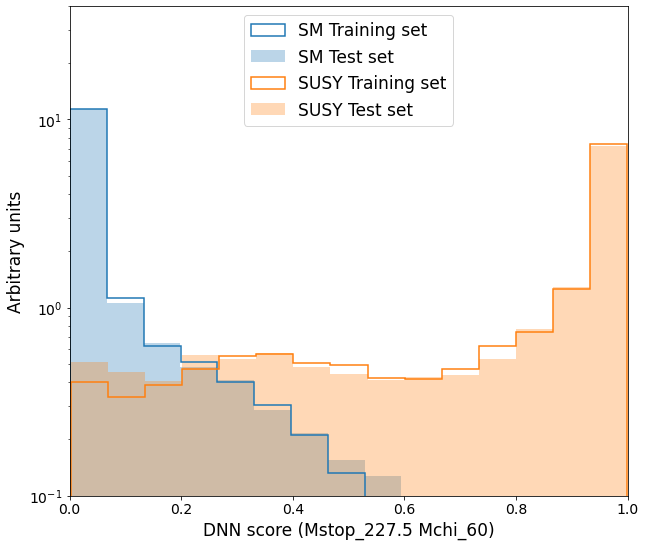

In [20]:
c0 = 'C0'
c1 = 'C1'
plt.figure(figsize=(10,9))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(y_pred_train[y_train == 0], bins=15, label='SM Training set', histtype='step', linestyle='solid', linewidth=1.5, density=True, color=c0)
plt.hist(y_pred_test[y_test == 0]  , bins=15, label='SM Test set'    , alpha=0.3, linewidth=1.5, density=True , color=c0)
plt.hist(y_pred_train[y_train == 1], bins=15, label='SUSY Training set', histtype='step' , linestyle='solid', linewidth=1.5, density=True, color=c1)
plt.hist(y_pred_test[y_test == 1]  , bins=15, label='SUSY Test set ', alpha=0.3, linewidth=1.5, density=True, color=c1)

plt.yscale('log')
plt.ylim(0.1, 40)
plt.xlim(0,1)
plt.xlabel('DNN score (Mstop_227.5 Mchi_60)', fontsize=17)
plt.ylabel('Arbitrary units', fontsize=17)
plt.legend(loc='upper center', fontsize=17)
#plt.savefig('Train vs test Mstop_227.5 Mchi_60.jpg')

In [72]:
def CorrMtx(df, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()
    sns.set(font_scale=1.4)
    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(15, 12))

    # Add diverging colormap from red to blue
    #cmap = sns.diverging_palette(250, 10, as_cmap=True)
    #cmap  = sns.color_palette("coolwarm")
    cmap = sns.diverging_palette(0,255,sep=1, as_cmap=True)
                                 
    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        hm = sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax, vmin=-1, vmax=1)
        plt.title('Correlation matrix for input features', fontsize=30)
        plt.savefig('ip_features_corr.png')
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax, vmin=-1, vmax=1)

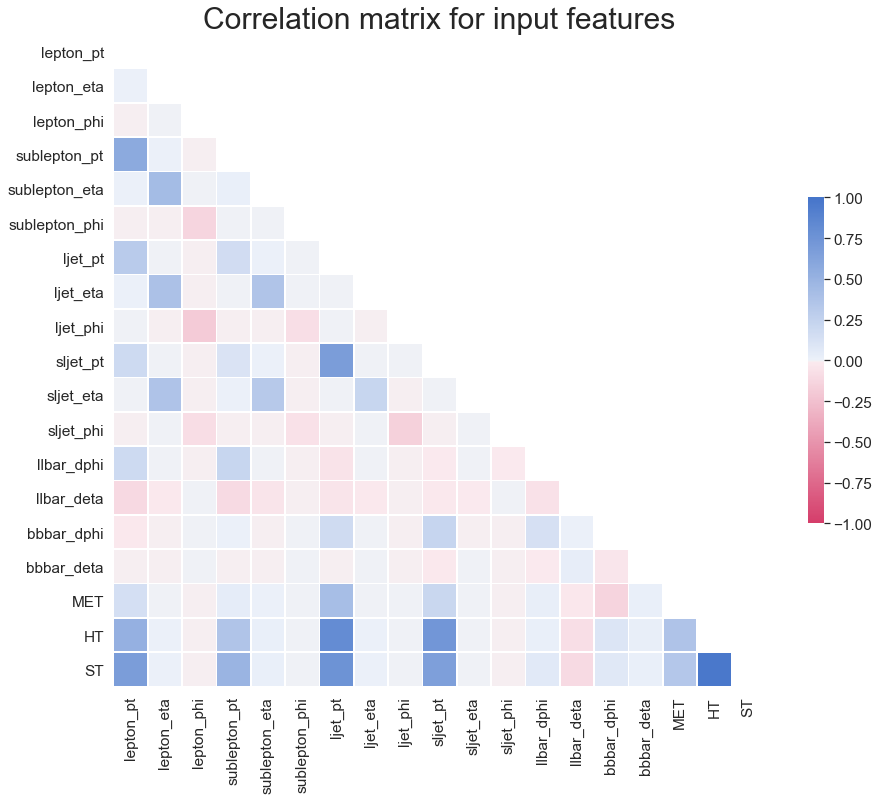

In [73]:
CorrMtx(corr, dropDuplicates = True)

In [71]:
w0 = np.loadtxt('Weights/SUSY/Mstop_227_5/Renorm/Renorm_variation_0.txt')
w1 = np.loadtxt('Weights/SUSY/Mstop_227_5/Renorm/Renorm_variation_1.txt')
w2 = np.loadtxt('Weights/SUSY/Mstop_227_5/Renorm/Renorm_variation_2.txt')
w3 = np.loadtxt('Weights/SUSY/Mstop_227_5/Renorm/Renorm_variation_3.txt')
w4 = np.loadtxt('Weights/SUSY/Mstop_227_5/Renorm/Renorm_variation_4.txt')
w6 = np.loadtxt('Weights/SUSY/Mstop_227_5/Renorm/Renorm_variation_6.txt')
w8 = np.loadtxt('Weights/SUSY/Mstop_227_5/Renorm/Renorm_variation_8.txt')

In [72]:
llbar_dphi = sig_df['llbar_dphi']

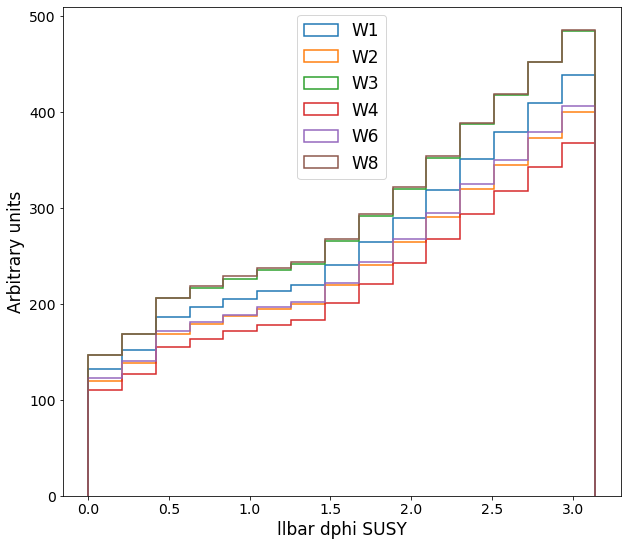

In [76]:
plt.figure(figsize=(10,9))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
#plt.hist(llbar_dphi, bins=15, label='W0', histtype='step', linewidth=1.5, weights=w0)
plt.hist(llbar_dphi, bins=15, label='W1', histtype='step', linewidth=1.5, weights=w1)
plt.hist(llbar_dphi, bins=15, label='W2', histtype='step', linewidth=1.5, weights=w2)
plt.hist(llbar_dphi, bins=15, label='W3', histtype='step', linewidth=1.5, weights=w3)
plt.hist(llbar_dphi, bins=15, label='W4', histtype='step', linewidth=1.5, weights=w4)
plt.hist(llbar_dphi, bins=15, label='W6', histtype='step', linewidth=1.5, weights=w6)
plt.hist(llbar_dphi, bins=15, label='W8', histtype='step', linewidth=1.5, weights=w8)
plt.xlabel('llbar dphi SUSY', fontsize=17)
plt.ylabel('Arbitrary units', fontsize=17)
plt.legend(loc='upper center', fontsize=17)

In [63]:
print(w0)
print(w1)

[1. 1. 1. ... 1. 1. 1.]
[0.11588 0.11588 0.11588 ... 0.11552 0.11552 0.11552]


In [65]:
w0 = np.loadtxt('Weights/ST/Renorm/Renorm_variation_0.txt')
w1 = np.loadtxt('Weights/ST/Renorm/Renorm_variation_1.txt')
w2 = np.loadtxt('Weights/ST/Renorm/Renorm_variation_2.txt')
w3 = np.loadtxt('Weights/ST/Renorm/Renorm_variation_3.txt')
w4 = np.loadtxt('Weights/ST/Renorm/Renorm_variation_4.txt')
w6 = np.loadtxt('Weights/ST/Renorm/Renorm_variation_6.txt')
w8 = np.loadtxt('Weights/ST/Renorm/Renorm_variation_8.txt')

In [66]:
st_llbar_dphi = st_df['llbar_dphi']

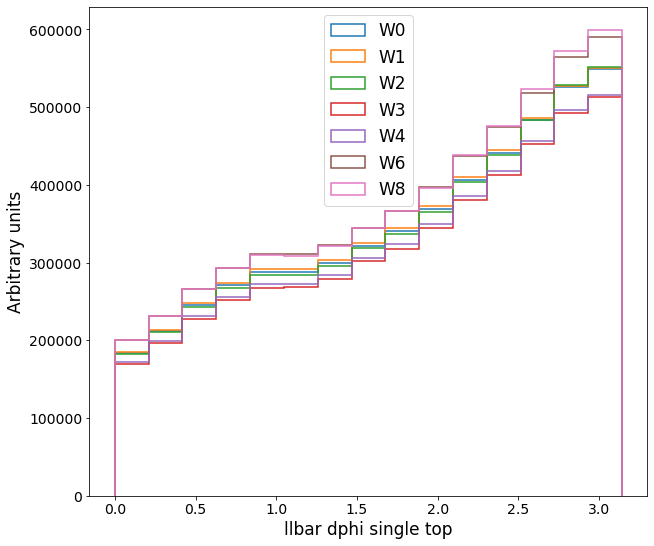

In [68]:
plt.figure(figsize=(10,9))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(st_llbar_dphi, bins=15, label='W0', histtype='step', linewidth=1.5, weights=w0)
plt.hist(st_llbar_dphi, bins=15, label='W1', histtype='step', linewidth=1.5, weights=w1)
plt.hist(st_llbar_dphi, bins=15, label='W2', histtype='step', linewidth=1.5, weights=w2)
plt.hist(st_llbar_dphi, bins=15, label='W3', histtype='step', linewidth=1.5, weights=w3)
plt.hist(st_llbar_dphi, bins=15, label='W4', histtype='step', linewidth=1.5, weights=w4)
plt.hist(st_llbar_dphi, bins=15, label='W6', histtype='step', linewidth=1.5, weights=w6)
plt.hist(st_llbar_dphi, bins=15, label='W8', histtype='step', linewidth=1.5, weights=w8)
plt.xlabel('llbar dphi single top', fontsize=17)
plt.ylabel('Arbitrary units', fontsize=17)
plt.legend(loc='upper center', fontsize=17)

In [69]:
print(w0)
print(w1)

[42.61399841 41.91999817 42.55400085 ... 43.27099991 42.23600006
 41.63600159]
[42.05699921 45.19499969 43.65299988 ... 43.65299988 44.49700165
 45.95700073]
